# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


In [3]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

# Generate waveform

In [4]:
delta_T = T*YRSID_SI/5000 # change amount of points here 
# im using 5000 as an extreme example to show the NaNs and non-zero values of the resulting waveform 
# for lower amount of points, the NaNs dominate
delta_T 

6311.629952709119

In [5]:
# %%time 
# # Calc trajectory
# (t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True)#upsampling=True, fix_t=True

# # Get amplitudes along trajectory
# teuk_modes = amp(a, p, e, x)

# # Get Ylms
# ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# cp.cuda.Stream.null.synchronize()

In [6]:
%%time 
# Calc trajectory

# with upsampling -> creates effect of dense stepping
# do consider if fix_T is needed 
(t_u, p_u, e_u, x_u, Phi_phi_u, Phi_theta_u, Phi_r_u) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True) 
spline_t_u = traj.integrator_spline_t.copy()  
spline_coeff_u = traj.integrator_spline_phase_coeff[:, [0, 2]].copy()

# without upsampling (default case)
(t_f, p_f, e_f, x_f, Phi_phi_f, Phi_theta_f, Phi_r_f) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt)
spline_t_f = traj.integrator_spline_t.copy() 
spline_coeff_f = traj.integrator_spline_phase_coeff[:, [0, 2]].copy()

# Get amplitudes along trajectory
teuk_modes_u = amp(a, p_u, e_u, x_u)
teuk_modes_f = amp(a, p_f, e_f, x_f)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 15.5 s, sys: 236 ms, total: 15.7 s
Wall time: 16 s


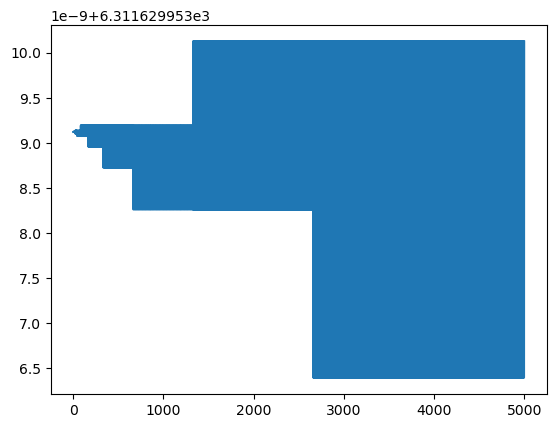

In [7]:
plt.plot(np.diff(t_u))

In [8]:
np.sum(np.isnan(teuk_modes_u[:,0]))

array(0)

In [9]:
teuk_modes_u[:,0]

array([1.55001444e-19-1.17375858e-19j, 1.54933897e-19-1.17318459e-19j,
       1.54866246e-19-1.17261023e-19j, ...,
       2.36011202e-20+4.52308678e-21j, 2.35000105e-20+4.51886407e-21j,
       2.33990847e-20+4.51462707e-21j], shape=(5000,))

In [10]:
teuk_modes_f[:,0]

array([ 1.55001444e-19-1.17375858e-19j,  1.54798968e-19-1.17203955e-19j,
        1.54123326e-19-1.16633588e-19j,  1.52351163e-19-1.15160112e-19j,
        1.46550711e-19-1.10533080e-19j,  1.19732401e-19-9.16095938e-20j,
       -5.01628811e-21-1.56952967e-20j,  6.00353032e-20+6.04473866e-21j,
        1.44892131e-19+5.24876564e-21j,  6.87672730e-20+5.27233384e-21j,
        2.32983432e-20+4.51037577e-21j])

In [11]:
# %%time

# t_gpu = cp.asarray(t)

# # need to prepare arrays for sum with all modes due to +/- m setup
# ls = amp.l_arr[: teuk_modes.shape[1]]
# ms = amp.m_arr[: teuk_modes.shape[1]]
# ns = amp.n_arr[: teuk_modes.shape[1]]

# keep_modes = np.arange(teuk_modes.shape[1])
# temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
#     keep_modes >= amp.num_m0
# ) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

# ylmkeep = np.concatenate([keep_modes, temp2])
# ylms_in = ylms[ylmkeep]
# teuk_modes_in = teuk_modes

# cp.cuda.Stream.null.synchronize()

In [12]:
%%time

t_u_gpu = cp.asarray(t_u)
t_f_gpu = cp.asarray(t_f)


# need to prepare arrays for sum with all modes due to +/- m setup
ls_u = amp.l_arr[: teuk_modes_u.shape[1]]
ls_f = amp.l_arr[: teuk_modes_f.shape[1]]

ms_u = amp.m_arr[: teuk_modes_u.shape[1]]
ms_f = amp.m_arr[: teuk_modes_f.shape[1]]

ns_u = amp.n_arr[: teuk_modes_u.shape[1]]
ns_f = amp.n_arr[: teuk_modes_f.shape[1]]

keep_modes_u = np.arange(teuk_modes_u.shape[1])
keep_modes_f = np.arange(teuk_modes_f.shape[1])

temp2_u = keep_modes_u * (keep_modes_u < amp.num_m0) + (keep_modes_u + amp.num_m_1_up) * (
    keep_modes_u >= amp.num_m0
) 

temp2_f = keep_modes_f * (keep_modes_f < amp.num_m0) + (keep_modes_f + amp.num_m_1_up) * (
    keep_modes_f >= amp.num_m0
) 

ylmkeep_u = np.concatenate([keep_modes_u, temp2_u])
ylmkeep_f = np.concatenate([keep_modes_f, temp2_f])

ylms_in_u = ylms[ylmkeep_u]
ylms_in_f = ylms[ylmkeep_f]

teuk_modes_in_u = teuk_modes_u
teuk_modes_in_f = teuk_modes_f


cp.cuda.Stream.null.synchronize()

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.75 ms


In [13]:
# %%time

# # perform summation
# waveform1 = interpolate_mode_sum(
#     t_gpu,
#     teuk_modes_in,
#     ylms_in,
#     traj.integrator_spline_t,
#     traj.integrator_spline_phase_coeff[:, [0, 2]],
#     ls,
#     ms,
#     ns,
#     dt=delta_T,
#     T=T,
# )

# cp.cuda.Stream.null.synchronize()

In [14]:
%%time

# perform summation
waveform1_u = interpolate_mode_sum(
    t_u_gpu,
    teuk_modes_in_u,
    ylms_in_u,
    spline_t_u,
    spline_coeff_u,
    ls_u,
    ms_u,
    ns_u,
    dt=dt, #using finer (small delta)t for the waveform
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 5min 50s, sys: 792 ms, total: 5min 51s
Wall time: 5min 51s


In [15]:
%%time

# interpolate only one mode 
waveform1_u_1 = interpolate_mode_sum(
    t_u_gpu,
    teuk_modes_in_u[:, 1:2],
    ylms_in_u[1:2],
    spline_t_u,
    spline_coeff_u,
    ls_u[1:2],
    ms_u[1:2],
    ns_u[1:2],
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 300 ms, sys: 12.9 ms, total: 313 ms
Wall time: 321 ms


In [16]:
len(waveform1_u)

3155184

In [17]:
waveform1_u_1[~np.isnan(waveform1_u_1)]

array([-8.91537819e-20+4.20871814e-20j, -8.91536081e-20+4.20870935e-20j,
       -8.91534344e-20+4.20870056e-20j, ...,
       -3.60559603e-20-9.21339478e-21j, -3.60560800e-20-9.21343355e-21j,
       -3.60561997e-20-9.21347233e-21j], shape=(43548,))

In [18]:
waveform1_u[~np.isnan(waveform1_u)]

array([ 0.22429852+0.19429072j,  0.22429852+0.19429072j,
        0.22429853+0.19429072j, ..., -0.03004328-0.17988086j,
       -0.03004328-0.17988087j, -0.03004328-0.17988087j], shape=(43548,))

In [19]:
np.sum(np.isnan(waveform1_u_1))

array(3111636)

In [20]:
# see if the nans appear for the same points
np.array_equal(~np.isnan(waveform1_u), ~np.isnan(waveform1_u_1))

array(True)

In [21]:
%%time
# just trying to see if we sample with delta_T instead 

# perform summation
waveform1_u_alt = interpolate_mode_sum(
    t_u_gpu,
    teuk_modes_in_u,
    ylms_in_u,
    spline_t_u,
    spline_coeff_u,
    ls_u,
    ms_u,
    ns_u,
    dt=delta_T,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 1min 38s, sys: 296 ms, total: 1min 38s
Wall time: 1min 38s


In [22]:
len(waveform1_u_alt)

5000

In [23]:
np.sum(np.isnan(waveform1_u_alt))

array(4935)

# Reference values for the waveform interpmodesum

In [24]:
%%time

# perform summation
waveform1_f = interpolate_mode_sum(
    t_f_gpu,
    teuk_modes_in_f,
    ylms_in_f,
    spline_t_f,
    spline_coeff_f,
    ls_f,
    ms_f,
    ns_f,
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 8.66 s, sys: 39.1 ms, total: 8.7 s
Wall time: 8.68 s


In [25]:
%%time
# Just one mode
# perform summation
waveform1_f_0 = interpolate_mode_sum(
    t_f_gpu,
    teuk_modes_in_f[:, 1:2],
    ylms_in_f[1:2],
    spline_t_f,
    spline_coeff_f,
    ls_f[1:2],
    ms_f[1:2],
    ns_f[1:2],
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 4.2 ms, sys: 1 ms, total: 5.21 ms
Wall time: 4.9 ms


In [26]:
np.sum(np.isnan(waveform1_f_0))

array(0)

# Factors, SNRs etc

In [27]:
# For reference vals im using the finer waveform
waveform1 = waveform1_f

N = int(len(waveform1)) 
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)
# Calculate distance dimensionless
dist = 1.0 #Gpc
factor = gwf.dist_factor(dist, m2)
waveform1_scaled = waveform1.get()/factor

In [28]:
hfull_f = gwf.freq_wave(waveform1_scaled)

SNR_ref = gwf.SNR(hfull_f)
print("SNR:", SNR_ref)
print("SNR squared:", SNR_ref**2)

SNR: 38.1970889944838
SNR squared: 1459.0176076525154


In [29]:
# for the following im going to use the upsampled ver 
N_traj = teuk_modes_u.shape[0]  # number of trajectory points
print("Number of trajectory points:", N_traj)
# delta_T = T_sd / N_traj  # time step in seconds
print("Time step in seconds", delta_T)

Number of trajectory points: 5000
Time step in seconds 6311.629952709119


In [30]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

# Generate mode frequencies 

Using *get_fundamental_frequencies* instead. TODO: pick only one (CPU/GPU)? which would be better in this case?

In [31]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p_u, e_u, x_u) #could use GPU here but im running to mismatch probs
#actually whats the benefit of running cpu -> convert gpu vs running all in gpu in the first place?

In [32]:
isinstance(amp.m_arr, cp.ndarray)

True

In [33]:
OmegaPhi.shape

(5000,)

In [34]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [35]:
gw_frequencies_per_mode = []

for idx in range(len(mode_labels)):
    # TODO: do convert this so everything is in either CPU/GPU?
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [36]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]

    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi_u + n * Phi_r_u
    
    gw_phase_per_mode.append(phi_mode)

# Calculate inner product

In [37]:
idx_i = 1165 # 220
idx_j = 1166 # 221
mode_labels[idx_i], mode_labels[idx_j]

('(2,2,0)', '(2,2,1)')

In [38]:
# Get complex amplitudes for the two modes
A0 = teuk_modes_u[:, idx_i]
A1 = teuk_modes_u[:, idx_j]
print("A_0:", A0)
print("A_1:", A1)

A_0: [0.44924664-0.12386828j 0.44926036-0.12387416j 0.44927408-0.12388005j ...
 0.54154811-0.16518926j 0.54157391-0.16520117j 0.54159972-0.16521309j]
A_1: [0.26093475-0.08208452j 0.26093519-0.08208561j 0.26093563-0.08208671j ...
 0.26226464-0.08779556j 0.26226481-0.08779673j 0.26226498-0.08779789j]


In [39]:
# Get sensitivity for the two modes
Sn0 = get_sensitivity(gw_frequencies_per_mode[idx_i], sens_fn=LISASens, return_type="PSD")
Sn1 = get_sensitivity(gw_frequencies_per_mode[idx_j], sens_fn=LISASens, return_type="PSD")

In [40]:
barA0 = A0.get() / np.sqrt(Sn0) #TODO: do convert this in C/GPU only?
barA0 

array([1.02549867e+19-2.82755056e+18j, 1.02549945e+19-2.82760060e+18j,
       1.02550023e+19-2.82765064e+18j, ...,
       1.01349309e+19-3.09147365e+18j, 1.01348581e+19-3.09152715e+18j,
       1.01347853e+19-3.09158064e+18j], shape=(5000,))

In [41]:
barA1 = A1.get() / np.sqrt(Sn1)
barA1

array([4.53923442e+18-1.42794654e+18j, 4.53910872e+18-1.42792367e+18j,
       4.53898301e+18-1.42790080e+18j, ...,
       3.76619865e+18-1.26077052e+18j, 3.76600587e+18-1.26072191e+18j,
       3.76581308e+18-1.26067329e+18j], shape=(5000,))

In [42]:
phase01 = np.abs(gw_phase_per_mode[idx_i] - gw_phase_per_mode[idx_j]) < 1.0 
phase01

array([ True, False, False, ..., False, False, False], shape=(5000,))

In [43]:
np.sum(phase01)

np.int64(1)

## Cross-term inner product of (2,2,0) & (2,2,1)

In [44]:
crossprod01 = np.conj(barA0[phase01]) * barA1[phase01]
crossprod01

array([5.05873796e+37-1.80865793e+36j])

In [45]:
inner_contrib_01 = np.sum(crossprod01) * delta_T * 1/(factor**2)
np.real(inner_contrib_01)

np.float64(0.07311779604111013)

## Self-term inner product of (2,2,0), (2,2,1)

In [46]:
selfprod00 = np.conj(barA0)*barA0 #barA0**2
selfprod00

array([1.13159794e+38-1.62405645e+21j, 1.13160237e+38-1.78497723e+21j,
       1.13160679e+38-1.04743827e+21j, ...,
       1.12274034e+38+6.70339342e+20j, 1.12272889e+38+1.88426876e+21j,
       1.12271744e+38+3.96193429e+20j], shape=(5000,))

In [47]:
inner_contrib_00 = np.sum(np.real(selfprod00)) * delta_T * 1/(factor**2)
inner_contrib_00

np.float64(819.1758316807028)

In [48]:
inner_contrib_11 = np.sum(np.real(np.conj(barA1)*barA1)) * delta_T * 1/(factor**2)
inner_contrib_11

np.float64(139.90582448534522)

In [49]:
np.abs(inner_contrib_01 / np.sqrt(inner_contrib_00 * inner_contrib_11) )

np.float64(0.00021611953703094865)

# Creating Inner Product Function

In [52]:
def calc_inner(idx_i, idx_j, teuk_modes, amp, freqs, phases, delta_T, factor):
    # Obtain the lmn-s
    l_i = amp.l_arr[idx_i]
    m_i = amp.m_arr[idx_i]
    n_i = amp.n_arr[idx_i]

    l_j = amp.l_arr[idx_j]
    m_j = amp.m_arr[idx_j]
    n_j = amp.n_arr[idx_j]

    # Get Teukolsky modes
    # Check if negative m 
    if m_i >= 0:
        A_i = teuk_modes[:, idx_i]

    elif m_i < 0:
        pos_m_mask_i = (amp.l_arr == l_i) & (amp.m_arr == -m_i) & (amp.n_arr == n_i)
        pos_m_idx_i = np.where(pos_m_mask_i)[0]
        A_i_pos = teuk_modes[:, pos_m_idx_i]
        A_i = (-1)**l_i * np.conj(A_i_pos)

    if m_j >= 0:
        A_j = teuk_modes[:, idx_j]
        
    elif m_j < 0:
        pos_m_mask_j = (amp.l_arr == l_j) & (amp.m_arr == -m_j) & (amp.n_arr == n_j)
        pos_m_idx_j = np.where(pos_m_mask_j)[0]
        A_j_pos = teuk_modes[:, pos_m_idx_j]
        A_j = (-1)**l_j * np.conj(A_j_pos)

    # Get sensitivity for each mode 
    Sn_i = get_sensitivity(freqs[idx_i], sens_fn=LISASens, return_type="PSD")
    Sn_j = get_sensitivity(freqs[idx_j], sens_fn=LISASens, return_type="PSD")

    # Get noise-weighted amplitudes
    bar_A_i = A_i.get() / np.sqrt(Sn_i)
    bar_A_j = A_j.get() / np.sqrt(Sn_j)

    # Get phase mask
    phase_mask = np.abs(phases[idx_i] - phases[idx_j]) < 1.0 

    # Calculate product
    prod = np.conj(bar_A_i[phase_mask]) * bar_A_j[phase_mask]

    # Calculate full inner product
    innerprod = np.sum(np.real(prod)) * delta_T * 1/(factor**2)

    return innerprod

In [53]:
# (2,2,0) & (2,2,0)
calc_inner(1165,1165, teuk_modes_u, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

np.float64(819.1758316807028)

In [54]:
# (2,2,0) & (2,2,1)
calc_inner(1165,1166, teuk_modes_u, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

np.float64(0.07311779604111013)

In [55]:
mode_labels[7159]

'(2,-2,0)'

In [56]:
# (2,2,0) & (2, -2, 0)
calc_inner(1165,7159, teuk_modes_u, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

np.float64(643.2564339123205)

# Reference values

In [57]:
indices = [1165, 1166, 7159]

In [67]:
waveform_per_mode = []
for idx in indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes_f[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes_f[:, [pos_m_idx]])
        print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t_f_gpu,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], 
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)

Mode:  (2,2,0)
Mode:  (2,2,1)
Mode:  (2,-2,0)
NEGATIVE M MODE
[2] [2] [0]
[1165]
[[[0.44924664+0.12386828j]]

 [[0.44928771+0.12388589j]]

 [[0.44942348+0.12394409j]]

 [[0.44977097+0.1240931j ]]

 [[0.45083585+0.12455013j]]

 [[0.45495384+0.12632279j]]

 [[0.47436319+0.13478633j]]

 [[0.49376997+0.14341229j]]

 [[0.51317459+0.15217708j]]

 [[0.53255914+0.16104611j]]

 [[0.54162553+0.16522501j]]]
[2.41402044e-18-0.03942395j]


In [68]:
# Convert each waveform to frequency domain
hf_per_mode = [gwf.freq_wave(waveform.get()) for waveform in waveform_per_mode]

In [69]:
# (2,2,0) & (2,2,0)
gwf.inner(hf_per_mode[0], hf_per_mode[0])

np.float64(585.7806007839152)

In [70]:
# (2,2,0) & (2,2,1)
gwf.inner(hf_per_mode[0], hf_per_mode[1])

np.float64(-0.005138531996463582)

In [71]:
# (2,2,0) & (2,-2,0)
gwf.inner(hf_per_mode[0], hf_per_mode[2])

np.float64(-54.802938893703626)